 # Оптимизация маркетинговых затрат Яндекс.Афиши на основании данных, полученных с июня 2017 по конец мая 2018 года

## Оглавление

## [Изучение общей информации](#step1)

#### [Таблица visits](#step2)

#### [Таблица orders](#step3)

#### [Таблица costs](#step4)

## [Отчёты и метрики](#step5)

### [ Продукт](#step6)

#### [Сколько людей пользуются в день, неделю, месяц?](#step7)

#### [Сколько сессий в день?](#step8)

#### [Сколько длится одна сессия?](#step9)

#### [Как часто люди возвращаются?](#step10)

### [ Продажи](#step11)

#### [Когда люди начинают покупать?](#step12)

#### [Сколько раз покупают за период?](#step13)

#### [Какой средний чек?](#step14)

#### [Сколько денег приносят? (LTV)](#step15)

### [Маркетинг](#step16)

#### [Сколько денег потратили? Всего / на каждый источник / по времени](#step17)

#### [Сколько стоило привлечение одного покупателя из каждого источника?](#step18)

#### [На сколько окупились расходы? (ROI)](#step19)

## [Общий вывод](#step5)

## Изучение общей информации <a name="step1"></a>

#### Таблица visits (лог сервера с информацией о посещениях сайта):
* Uid — уникальный идентификатор пользователя
* Device — категория устройства пользователя
* Start Ts — дата и время начала сессии
* End Ts — дата и время окончания сессии
* Source Id — идентификатор рекламного источника, из которого пришел пользователь
#### Таблица orders (информация о заказах):
* Uid — уникальный id пользователя, который сделал заказ
* Buy Ts — дата и время заказа
* Revenue — выручка Яндекс.Афиши с этого заказа
#### Таблица costs (информация о затратах на маркетинг):
* source_id — идентификатор рекламного источника
* dt — дата
* costs — затраты на этот рекламный источник в этот день

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy import stats as st

In [2]:
#Загружим датасеты
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

#### Таблица visits<a name="step2"></a>

In [3]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Сразу бросается в глаза, названия столбцов, а также,что столбцы с датами не в том формате, в котором нужно. Переименуем столбцы и переведем столбцы с датами в формат datetime.

In [5]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
#Немного поменяем порядок, а то все столбцы в разброс как то, путает
visits = visits[['uid', 'device', 'start_ts', 'end_ts', 'source_id']]

In [6]:
visits.head()

,uid,device,start_ts,end_ts,source_id
0,16879256277535980062,touch,2017-12-20 17:20:00,2017-12-20 17:38:00,4
1,104060357244891740,desktop,2018-02-19 16:53:00,2018-02-19 17:21:00,2
2,7459035603376831527,touch,2017-07-01 01:54:00,2017-07-01 01:54:00,5
3,16174680259334210214,desktop,2018-05-20 10:59:00,2018-05-20 11:23:00,9
4,9969694820036681168,desktop,2017-12-27 14:06:00,2017-12-27 14:06:00,3


In [7]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format = '%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format = '%Y-%m-%d %H:%M:%S')

In [8]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
uid          359400 non-null uint64
device       359400 non-null object
start_ts     359400 non-null datetime64[ns]
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [9]:
visits.describe()

,uid,source_id
count,3.594000e+05,359400.000000
mean,9.202557e+18,3.750515
std,5.298433e+18,1.917116
min,1.186350e+13,1.000000
25%,4.613407e+18,3.000000
50%,9.227413e+18,4.000000
75%,1.372824e+19,5.000000
max,1.844668e+19,10.000000


In [10]:
visits.isnull().sum()

uid          0
device       0
start_ts     0
end_ts       0
source_id    0
dtype: int64

In [11]:
visits.duplicated().sum()

0

#### Таблица orders<a name="step3"></a>

In [12]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Название столбцов и неправильный формат дат, как и в предыдущей таблице

In [14]:
orders.columns = ['buy_ts','revenue', 'uid']
orders = orders[['uid', 'buy_ts', 'revenue']]

In [15]:
orders.head()

,uid,buy_ts,revenue
0,10329302124590727494,2017-06-01 00:10:00,17.00
1,11627257723692907447,2017-06-01 00:25:00,0.55
2,17903680561304213844,2017-06-01 00:27:00,0.37
3,16109239769442553005,2017-06-01 00:29:00,0.55
4,14200605875248379450,2017-06-01 07:58:00,0.37


In [16]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format = '%Y-%m-%d %H:%M:%S')

In [17]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
uid        50415 non-null uint64
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [18]:
orders.isnull().sum()

uid        0
buy_ts     0
revenue    0
dtype: int64

In [19]:
orders.duplicated().sum()

0

#### Таблица costs<a name="step4"></a>

In [20]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [21]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [22]:
costs.columns = ['source_id','date', 'costs']

In [23]:
costs['date'] = pd.to_datetime(costs['date'], format = '%Y-%m-%d %H:%M:%S')

In [24]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
date         2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [25]:
costs.isnull().sum()

source_id    0
date         0
costs        0
dtype: int64

In [26]:
costs.duplicated().sum()

0

Данные в таблицах чистые, без дубликатов и пропусков. Произведена процедура перевода дат в необходимый формат.

## Отчёты и метрики<a name="step5"></a>

### Продукт<a name="step6"></a>

#### Сколько людей пользуются в день, неделю, месяц?<a name="step7"></a>

In [27]:
visits.head()

,uid,device,start_ts,end_ts,source_id
0,16879256277535980062,touch,2017-12-20 17:20:00,2017-12-20 17:38:00,4
1,104060357244891740,desktop,2018-02-19 16:53:00,2018-02-19 17:21:00,2
2,7459035603376831527,touch,2017-07-01 01:54:00,2017-07-01 01:54:00,5
3,16174680259334210214,desktop,2018-05-20 10:59:00,2018-05-20 11:23:00,9
4,9969694820036681168,desktop,2017-12-27 14:06:00,2017-12-27 14:06:00,3


Из столбца с датой выделяем в отдельные столбцы день, месяц, неделю и год

In [28]:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

In [29]:
visits.head()

,uid,device,start_ts,end_ts,source_id,session_year,session_month,session_week,session_date
0,16879256277535980062,touch,2017-12-20 17:20:00,2017-12-20 17:38:00,4,2017,12,51,2017-12-20
1,104060357244891740,desktop,2018-02-19 16:53:00,2018-02-19 17:21:00,2,2018,2,8,2018-02-19
2,7459035603376831527,touch,2017-07-01 01:54:00,2017-07-01 01:54:00,5,2017,7,26,2017-07-01
3,16174680259334210214,desktop,2018-05-20 10:59:00,2018-05-20 11:23:00,9,2018,5,20,2018-05-20
4,9969694820036681168,desktop,2017-12-27 14:06:00,2017-12-27 14:06:00,3,2017,12,52,2017-12-27


#### Среднее количество пользователей в день

In [30]:
dau = visits.groupby(visits['start_ts'].astype('datetime64[D]')).agg({'uid': 'nunique'}).reset_index()

In [31]:
dau.mean()

uid    907.991758
dtype: float64

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


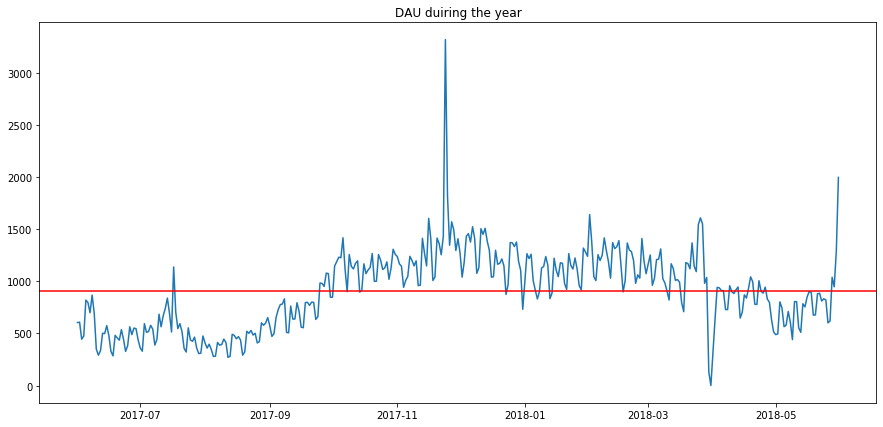

In [32]:
plt.figure(figsize=(15,7))
plt.title('DAU duiring the year')
plt.plot(dau['start_ts'], dau['uid'])
plt.axhline(y = 907.991758, color = 'red')

In [33]:
dau.sort_values(by = 'uid', ascending = False).head()

,start_ts,uid
176,2017-11-24,3319
363,2018-05-31,1997
177,2017-11-25,1817
245,2018-02-01,1640
298,2018-03-26,1609


In [34]:
dau.sort_values(by = 'uid', ascending = True).head()

,start_ts,uid
303,2018-03-31,1
302,2018-03-30,131
72,2017-08-12,271
65,2017-08-05,280
73,2017-08-13,281


В конце ноября 2017 виден скачок как на графике, так и по таблице. В этот период пользователей за день было больше всего. В конце марта 2018 наоборот, меньше всего. В среднем, каждый день заходит около 900 человек

#### Среднее количество пользователей в неделю

In [35]:
wau = visits.groupby(visits['start_ts'].astype('datetime64[W]')).agg({'uid': 'nunique'}).reset_index()

In [36]:
wau.mean()

uid    5724.415094
dtype: float64

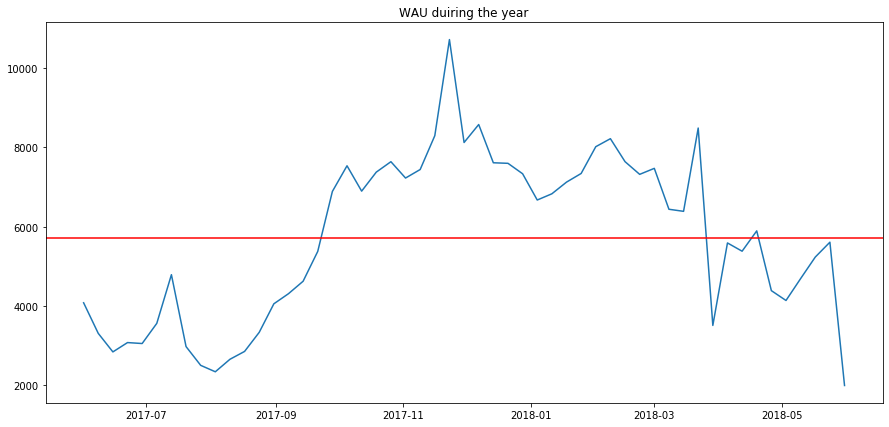

In [37]:
plt.figure(figsize=(15,7))
plt.title('WAU duiring the year')
plt.plot(wau['start_ts'], wau['uid'])
plt.axhline(y = 5724.415094, color = 'red')

In [38]:
wau.sort_values(by = 'uid', ascending = False).head()

,start_ts,uid
25,2017-11-23,10716
27,2017-12-07,8575
42,2018-03-22,8486
24,2017-11-16,8294
36,2018-02-08,8218


In [39]:
wau.sort_values(by = 'uid', ascending = True).head()

,start_ts,uid
52,2018-05-31,1997
9,2017-08-03,2343
8,2017-07-27,2505
10,2017-08-10,2658
2,2017-06-15,2844


Самое большое количество людей за неделю пришлось на конец ноября 2017. На конец мая 2018- самое маленькое. В среднем заходили почти 6000 раз в неделю

#### Среднее количество пользователей в месяц

In [40]:
mau = visits.groupby(visits['start_ts'].astype('datetime64[M]')).agg({'uid': 'nunique'}).reset_index()

In [41]:
mau.mean()

uid    23228.416667
dtype: float64

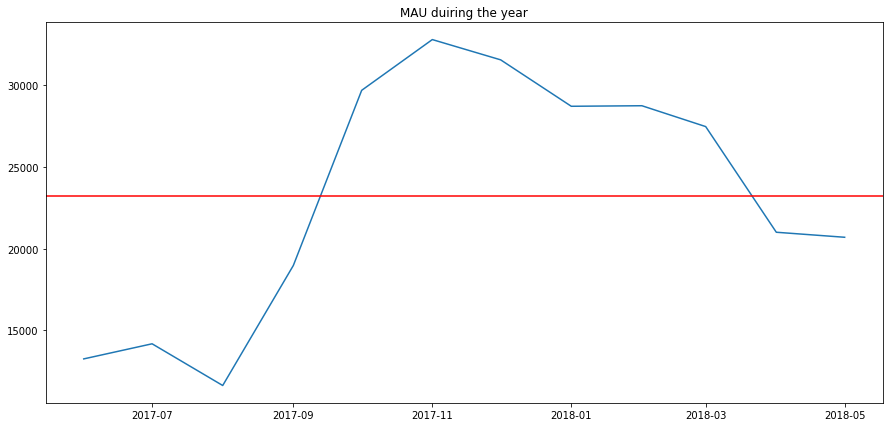

In [42]:
plt.figure(figsize=(15,7))
plt.title('MAU duiring the year')
plt.plot(mau['start_ts'], mau['uid'])
plt.axhline(y = 23228.416667, color = 'red')

In [43]:
mau.sort_values(by = 'uid', ascending = False).head()

,start_ts,uid
5,2017-11-01,32797
6,2017-12-01,31557
4,2017-10-01,29692
8,2018-02-01,28749
7,2018-01-01,28716


In [44]:
mau.sort_values(by = 'uid', ascending = True).head()

,start_ts,uid
2,2017-08-01,11631
0,2017-06-01,13259
1,2017-07-01,14183
3,2017-09-01,18975
11,2018-05-01,20701


Самое большое количество людей за месяц пришлось на конец ноября. На конец августа 2017-самое маленькое. В среднем заходили почти 23000 раз в неделю

#### Сколько сессий в день?<a name="step8"></a>

In [45]:
sessions_per_day = visits.groupby('session_date').agg({'uid': 'count'}).reset_index()

In [46]:
sessions_per_day.mean()

uid    987.362637
dtype: float64

In [47]:
sessions_per_day.sort_values(by = 'uid', ascending = False).head()

,session_date,uid
176,2017-11-24,4042
363,2018-05-31,2256
177,2017-11-25,2089
245,2018-02-01,1878
298,2018-03-26,1796


In [48]:
sessions_per_day.sort_values(by = 'uid', ascending = True).head()

,session_date,uid
303,2018-03-31,1
302,2018-03-30,134
73,2017-08-13,293
72,2017-08-12,296
66,2017-08-06,296


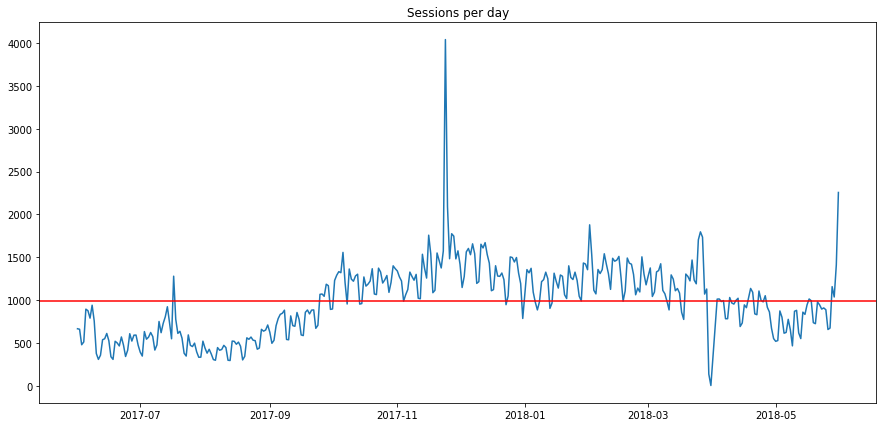

In [49]:
plt.figure(figsize=(15,7))
plt.title('Sessions per day')
plt.plot(sessions_per_day['session_date'], sessions_per_day['uid'])
plt.axhline(y =  987.362637, color = 'red')

In [50]:
sessions_per_day.sort_values(by = 'uid', ascending = False).head()

,session_date,uid
176,2017-11-24,4042
363,2018-05-31,2256
177,2017-11-25,2089
245,2018-02-01,1878
298,2018-03-26,1796


In [51]:
sessions_per_day.sort_values(by = 'uid', ascending = True).head()

,session_date,uid
303,2018-03-31,1
302,2018-03-30,134
73,2017-08-13,293
72,2017-08-12,296
66,2017-08-06,296


Данные показатели, опять же, говорят о том, что в конце ноября самая большая активность. Не знаю, с чем это может быть связано

В общем и целом, дела в 2018 году шли почти также, как и в 2017. Были как спады, так и подъемы. Но, почему то, в конце ноября 2017 года общая картина пошла на спад.

#### Сколько длится одна сессия?<a name="step9"></a>

In [52]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [53]:
#в секундах
visits['session_duration_sec'].mean()

643.506488592098

In [54]:
#в минутах
visits['session_duration_sec'].mean()/60

10.725108143201632

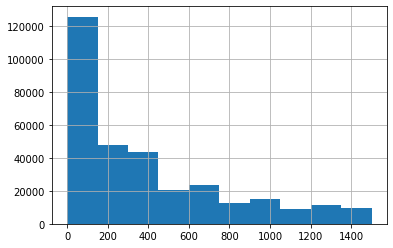

In [55]:
visits['session_duration_sec'].hist(bins=10, range=(0, 1500))

Рассчитаем еще и по моду (значение в выборке, которое встречается чаще всего)

In [56]:
#в секундах
visits['session_duration_sec'].mode()

0    60
dtype: int64

In [57]:
#в минутах
visits['session_duration_sec'].mode()/60

0    1.0
dtype: float64

Одна сессия длится, в среднем, почти 11 минут, по моду 1 минуту.

В общем и целом, мне кажется, что 11 минут вполне достаточно для того, что бы купить билет. Одна минута-ну очень мало. Наверное они зашли и резко передумали или по ошибке нажали не на ту вкладку

#### Как часто люди возвращаются?<a name="step10"></a>

In [58]:
visits.head()

,uid,device,start_ts,end_ts,source_id,session_year,session_month,session_week,session_date,session_duration_sec
0,16879256277535980062,touch,2017-12-20 17:20:00,2017-12-20 17:38:00,4,2017,12,51,2017-12-20,1080
1,104060357244891740,desktop,2018-02-19 16:53:00,2018-02-19 17:21:00,2,2018,2,8,2018-02-19,1680
2,7459035603376831527,touch,2017-07-01 01:54:00,2017-07-01 01:54:00,5,2017,7,26,2017-07-01,0
3,16174680259334210214,desktop,2018-05-20 10:59:00,2018-05-20 11:23:00,9,2018,5,20,2018-05-20,1440
4,9969694820036681168,desktop,2017-12-27 14:06:00,2017-12-27 14:06:00,3,2017,12,52,2017-12-27,0


In [59]:
first_time_session= visits.groupby('uid')['start_ts'].min()
first_time_session.head()

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: start_ts, dtype: datetime64[ns]

In [60]:
first_time_session.name = 'first_time_session'
visits = visits.join(first_time_session, on = 'uid') 

In [61]:
visits.head()

,uid,device,start_ts,end_ts,source_id,session_year,session_month,session_week,session_date,session_duration_sec,first_time_session
0,16879256277535980062,touch,2017-12-20 17:20:00,2017-12-20 17:38:00,4,2017,12,51,2017-12-20,1080,2017-12-20 17:20:00
1,104060357244891740,desktop,2018-02-19 16:53:00,2018-02-19 17:21:00,2,2018,2,8,2018-02-19,1680,2018-02-19 16:53:00
2,7459035603376831527,touch,2017-07-01 01:54:00,2017-07-01 01:54:00,5,2017,7,26,2017-07-01,0,2017-07-01 01:54:00
3,16174680259334210214,desktop,2018-05-20 10:59:00,2018-05-20 11:23:00,9,2018,5,20,2018-05-20,1440,2018-03-09 20:05:00
4,9969694820036681168,desktop,2017-12-27 14:06:00,2017-12-27 14:06:00,3,2017,12,52,2017-12-27,0,2017-12-27 14:06:00


In [62]:
visits['first_session_month'] = visits['first_time_session'].astype('datetime64[M]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')

В новый столбец lifetime запишем разницу между месяцем первой сессии и последней. Найдем число месяцев, прошедших между датами

In [63]:
visits['lifetime'] = (visits['session_month'] - visits['first_session_month']) / np.timedelta64(1, 'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')

In [64]:
visits_grouped_by_cohorts = visits.groupby(['first_session_month', 'lifetime']).agg({'uid': 'nunique'}).reset_index()

Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю

In [65]:
initial_users_count = visits_grouped_by_cohorts[visits_grouped_by_cohorts['lifetime'] == 0][['first_session_month', 'uid']]
initial_users_count.columns = ['first_session_month', 'cohort_uid']
initial_users_count

,first_session_month,cohort_uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Посмотрим, как изменяется возвращаемость с течением времени. Объединим данные по когортам с исходным количеством пользователей в когорте. Далее рассчитаем Retention Rate. Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте

In [66]:
visits_grouped_by_cohorts = visits_grouped_by_cohorts.merge(initial_users_count)
visits_grouped_by_cohorts['retention'] = visits_grouped_by_cohorts['uid'] / visits_grouped_by_cohorts['cohort_uid']
pivot = visits_grouped_by_cohorts.pivot_table(index = 'first_session_month',columns = 'lifetime', values = 'retention', aggfunc = 'sum')
pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Для визуализации построим тепловую карту

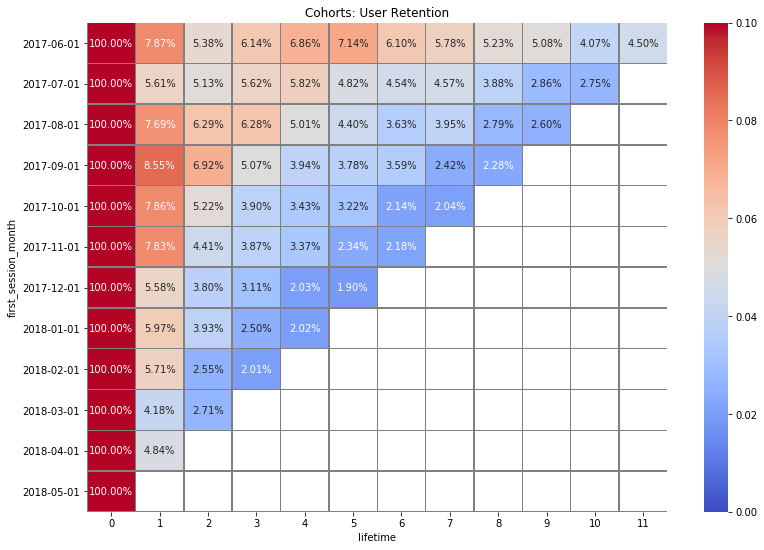

In [67]:
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(pivot, annot=True, fmt='.2%', vmin=0, vmax=0.1, center= 0.05, linewidths=0.5,cmap= 'coolwarm', linecolor='grey').set_yticklabels(pivot.index.date);

### Продажи<a name="step11"></a>

#### • Когда люди начинают покупать?<a name="step12"></a>

In [68]:
orders.head()

,uid,buy_ts,revenue
0,10329302124590727494,2017-06-01 00:10:00,17.00
1,11627257723692907447,2017-06-01 00:25:00,0.55
2,17903680561304213844,2017-06-01 00:27:00,0.37
3,16109239769442553005,2017-06-01 00:29:00,0.55
4,14200605875248379450,2017-06-01 07:58:00,0.37


In [69]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
uid        50415 non-null uint64
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


Сгруппируем и изменим названия для того, что бы не было задвоения

In [70]:
first_buying = orders.groupby('uid').agg({'buy_ts':'min'}).reset_index()
first_buying= first_buying.rename(columns={'buy_ts':'first_buying_date'})
first_buying.head()

,uid,first_buying_date
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


In [71]:
visits.head()

,uid,device,start_ts,end_ts,source_id,session_year,session_month,session_week,session_date,session_duration_sec,first_time_session,first_session_month,lifetime
0,16879256277535980062,touch,2017-12-20 17:20:00,2017-12-20 17:38:00,4,2017,2017-12-01,51,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,0
1,104060357244891740,desktop,2018-02-19 16:53:00,2018-02-19 17:21:00,2,2018,2018-02-01,8,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,0
2,7459035603376831527,touch,2017-07-01 01:54:00,2017-07-01 01:54:00,5,2017,2017-07-01,26,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,0
3,16174680259334210214,desktop,2018-05-20 10:59:00,2018-05-20 11:23:00,9,2018,2018-05-01,20,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2
4,9969694820036681168,desktop,2017-12-27 14:06:00,2017-12-27 14:06:00,3,2017,2017-12-01,52,2017-12-27,0,2017-12-27 14:06:00,2017-12-01,0


In [72]:
first_visits= visits.groupby('uid').agg({'start_ts':'min'}).reset_index()
first_visits=first_visits.rename(columns={'start_ts':'first_visits_date'})
first_visits.head()

,uid,first_visits_date
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [73]:
buying = first_buying.merge(first_visits, on = 'uid')
buying.head()

,uid,first_buying_date,first_visits_date
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [74]:
buying['buying_second'] = (buying['first_buying_date'] - buying['first_visits_date']).dt.seconds

In [75]:
buying['buying_second'].mean()

14949.881444569175

In [76]:
# в минутах
(buying['buying_second']/60).mean()

249.1646907428196

In [77]:
(buying['buying_second']/60).median()

16.0

In [78]:
(buying['buying_second']/60).mode()

0    1.0
dtype: float64

Text(0.5, 1.0, 'Time from entry to purchase')

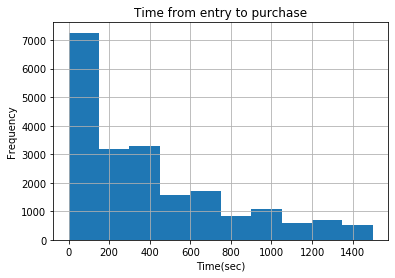

In [79]:
ax = buying['buying_second'].hist(bins=10, range=(0, 1500))
ax.set_xlabel('Time(sec)')
ax.set_ylabel('Frequency')
ax.set_title('Time from entry to purchase')

Судя по медиане, людям хватает 18 минут, с момента захода на сайт, что бы выбрать и купить то, что они хотели. По моду получается 1 минута, но это, скорее всего, те, кто сразу знал, чего хотел и сразу это купил.

#### Сколько раз покупают за период?<a name="step13"></a>

Разделим дату покупки на день, месяц, неделю

In [80]:
orders['buying_month'] = orders['buy_ts'].dt.month
orders['buying_week'] = orders['buy_ts'].dt.week
orders['buying_date'] = orders['buy_ts'].dt.date

In [81]:
orders.head()

,uid,buy_ts,revenue,buying_month,buying_week,buying_date
0,10329302124590727494,2017-06-01 00:10:00,17.00,6,22,2017-06-01
1,11627257723692907447,2017-06-01 00:25:00,0.55,6,22,2017-06-01
2,17903680561304213844,2017-06-01 00:27:00,0.37,6,22,2017-06-01
3,16109239769442553005,2017-06-01 00:29:00,0.55,6,22,2017-06-01
4,14200605875248379450,2017-06-01 07:58:00,0.37,6,22,2017-06-01


Если пойти по пути наименьшего сопротивления, все необходимые нам данные мы можем получить, обратившись к describe()

В день:

In [82]:
buying_per_day = orders.groupby('buying_date').agg({'uid' : 'count'}).describe().reset_index()
buying_per_day

,index,uid
0,count,364.000000
1,mean,138.502747
2,std,76.858480
3,min,1.000000
4,25%,82.750000
5,50%,136.000000
6,75%,177.000000
7,max,814.000000


Неделю:

In [83]:
buying_per_week =  orders.groupby('buying_week').agg({'uid' : 'count'}).describe().reset_index()
buying_per_week

,index,uid
0,count,52.000000
1,mean,969.519231
2,std,397.630457
3,min,314.000000
4,25%,658.500000
5,50%,997.500000
6,75%,1270.500000
7,max,1894.000000


Месяц:

In [84]:
buying_per_month=  orders.groupby('buying_month').agg({'uid' : 'count'}).describe().reset_index()
buying_per_month

,index,uid
0,count,12.000000
1,mean,4201.250000
2,std,1511.861052
3,min,1807.000000
4,25%,3045.500000
5,50%,4533.500000
6,75%,5409.250000
7,max,6218.000000


In [85]:
buying_per_dayweek = buying_per_day.merge(buying_per_week, on = 'index')
united_buying = buying_per_dayweek.merge(buying_per_month, on = 'index')
united_buying.columns = ['parameter', 'per_day ', 'per_week', 'per_month']
united_buying
#знаю, что получилось не очень, если бы вы подсказали, как сделать получше, была бы очень благодарна

,parameter,per_day,per_week,per_month
0,count,364.000000,52.000000,12.000000
1,mean,138.502747,969.519231,4201.250000
2,std,76.858480,397.630457,1511.861052
3,min,1.000000,314.000000,1807.000000
4,25%,82.750000,658.500000,3045.500000
5,50%,136.000000,997.500000,4533.500000
6,75%,177.000000,1270.500000,5409.250000
7,max,814.000000,1894.000000,6218.000000


In [86]:
buying_per_month_count = orders.groupby('buying_month').agg({'uid' : 'count'}).reset_index()
buying_per_month_count= buying_per_month_count.rename(columns={'uid':'buying_count'})
buying_per_month_count

,buying_month,buying_count
0,1,4721
1,2,5281
2,3,5326
3,4,3273
4,5,4346
5,6,2355
6,7,2363
7,8,1807
8,9,3387
9,10,5679


In [87]:
buying_per_month_nunique = orders.groupby('buying_month').agg({'uid' : 'nunique'}).reset_index()
buying_per_month_nunique = buying_per_month_nunique.rename(columns={'uid':'buyer_count'})
buying_per_month_nunique

,buying_month,buyer_count
0,1,3898
1,2,4258
2,3,4181
3,4,2744
4,5,3544
5,6,2024
6,7,1984
7,8,1472
8,9,2750
9,10,4675


In [88]:
buying_per_month_one_people = buying_per_month_count.merge(buying_per_month_nunique)
buying_per_month_one_people ['one_people'] = buying_per_month_one_people['buying_count']/buying_per_month_one_people['buyer_count']

In [89]:
buying_per_month_one_people

,buying_month,buying_count,buyer_count,one_people
0,1,4721,3898,1.211134
1,2,5281,4258,1.240254
2,3,5326,4181,1.273858
3,4,3273,2744,1.192784
4,5,4346,3544,1.226298
5,6,2355,2024,1.163538
6,7,2363,1984,1.191028
7,8,1807,1472,1.227582
8,9,3387,2750,1.231636
9,10,5679,4675,1.214759


In [90]:
buying_per_month_one_people['one_people'].mean()

1.222968553416106

#### Какой средний чек?<a name="step14"></a>

In [91]:
orders.head()

,uid,buy_ts,revenue,buying_month,buying_week,buying_date
0,10329302124590727494,2017-06-01 00:10:00,17.00,6,22,2017-06-01
1,11627257723692907447,2017-06-01 00:25:00,0.55,6,22,2017-06-01
2,17903680561304213844,2017-06-01 00:27:00,0.37,6,22,2017-06-01
3,16109239769442553005,2017-06-01 00:29:00,0.55,6,22,2017-06-01
4,14200605875248379450,2017-06-01 07:58:00,0.37,6,22,2017-06-01


In [92]:
average_check_per_month = orders.groupby('buying_month').agg({'revenue': 'mean'}).reset_index()
average_check_per_month

,buying_month,revenue
0,1,4.112927
1,2,4.840095
2,3,5.413930
3,4,5.150645
4,5,4.771279
5,6,4.059834
6,7,5.306589
7,8,4.847139
8,9,5.416448
9,10,4.928280


In [93]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [94]:
average_check_per_month['buying_month'] = months

In [95]:
average_check_per_month

,buying_month,revenue
0,January,4.112927
1,February,4.840095
2,March,5.413930
3,April,5.150645
4,May,4.771279
5,June,4.059834
6,July,5.306589
7,August,4.847139
8,September,5.416448
9,October,4.928280


Text(0.5, 1.0, 'Average check per month')

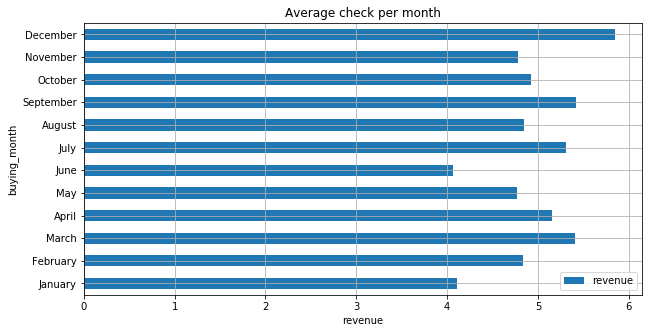

In [96]:
ax = average_check_per_month.plot(x='buying_month', y='revenue', kind='barh', grid = True, figsize = (10,5))
ax.set_xlabel('revenue')
ax.set_ylabel('buying_month')
ax.set_title('Average check per month')

Средний чек колеблется от 4 до 6. Самый большой в декабре, возможно кто то покупает билеты в подарок на новый год ☻

Рассмотрим изменения среднего чека в когортах по месяцу совершения покупки

In [97]:
first_order_date_by_customers = orders.groupby('uid')['buy_ts'].min()
first_order_date_by_customers.name = 'first_buying_date'
first_order_date_by_customers

uid
313578113262317        2018-01-03 21:51:00
1575281904278712       2017-06-03 10:13:00
2429014661409475       2017-10-11 18:33:00
2464366381792757       2018-01-28 15:54:00
2551852515556206       2017-11-24 10:14:00
                               ...        
18445147675727495770   2017-11-24 09:03:00
18445407535914413204   2017-09-22 23:55:00
18445601152732270159   2018-03-26 22:54:00
18446156210226471712   2018-02-18 19:34:00
18446167067214817906   2017-10-17 10:16:00
Name: first_buying_date, Length: 36523, dtype: datetime64[ns]

In [98]:
orders = orders.merge(first_order_date_by_customers,on= 'uid')
orders['first_buying_month'] = orders['first_buying_date'].astype('datetime64[M]')
orders['buying_month'] = orders['buy_ts'].astype('datetime64[M]')
orders

,uid,buy_ts,revenue,buying_month,buying_week,buying_date,first_buying_date,first_buying_month
0,10329302124590727494,2017-06-01 00:10:00,17.00,2017-06-01,22,2017-06-01,2017-06-01 00:10:00,2017-06-01
1,11627257723692907447,2017-06-01 00:25:00,0.55,2017-06-01,22,2017-06-01,2017-06-01 00:25:00,2017-06-01
2,17903680561304213844,2017-06-01 00:27:00,0.37,2017-06-01,22,2017-06-01,2017-06-01 00:27:00,2017-06-01
3,16109239769442553005,2017-06-01 00:29:00,0.55,2017-06-01,22,2017-06-01,2017-06-01 00:29:00,2017-06-01
4,14200605875248379450,2017-06-01 07:58:00,0.37,2017-06-01,22,2017-06-01,2017-06-01 07:58:00,2017-06-01
...,...,...,...,...,...,...,...,...
50410,12296626599487328624,2018-05-31 23:50:00,4.64,2018-05-01,22,2018-05-31,2018-05-31 23:50:00,2018-05-01
50411,11369640365507475976,2018-05-31 23:50:00,5.80,2018-05-01,22,2018-05-31,2018-05-31 23:50:00,2018-05-01
50412,1786462140797698849,2018-05-31 23:54:00,0.30,2018-05-01,22,2018-05-31,2018-05-31 23:54:00,2018-05-01
50413,3993697860786194247,2018-05-31 23:56:00,3.67,2018-05-01,22,2018-05-31,2018-05-31 23:56:00,2018-05-01


In [99]:
buying_grouped_by_cohorts = orders.groupby(['first_buying_month','buying_month']).agg({'revenue':'sum','uid':'nunique'})

In [100]:
buying_grouped_by_cohorts['revenue_per_user'] = buying_grouped_by_cohorts['revenue'] / buying_grouped_by_cohorts['uid']

In [101]:
buying_grouped_by_cohorts.pivot_table(index='first_buying_month',columns='buying_month',values='revenue_per_user',aggfunc='mean') 

buying_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_buying_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151,NaN
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026,NaN


Среднее по столбцу со средним чеком покупателя revenue_per_user

In [102]:
buying_grouped_by_cohorts['revenue_per_user'].mean()

14.733567597262237

#### Сколько денег приносят? (LTV)<a name="step15"></a>

LTV удобно считать по когортам. Вспомним, что для этого нужно:
* найти дату первой покупки каждого покупателя;
* вычислить число новых покупателей за каждую дату;
* добавить дату первой покупки в таблицу с заказами;
* сгруппировать таблицу и посчитать выручку.

In [103]:
orders.head()

,uid,buy_ts,revenue,buying_month,buying_week,buying_date,first_buying_date,first_buying_month
0,10329302124590727494,2017-06-01 00:10:00,17.00,2017-06-01,22,2017-06-01,2017-06-01 00:10:00,2017-06-01
1,11627257723692907447,2017-06-01 00:25:00,0.55,2017-06-01,22,2017-06-01,2017-06-01 00:25:00,2017-06-01
2,17903680561304213844,2017-06-01 00:27:00,0.37,2017-06-01,22,2017-06-01,2017-06-01 00:27:00,2017-06-01
3,16109239769442553005,2017-06-01 00:29:00,0.55,2017-06-01,22,2017-06-01,2017-06-01 00:29:00,2017-06-01
4,14200605875248379450,2017-06-01 07:58:00,0.37,2017-06-01,22,2017-06-01,2017-06-01 07:58:00,2017-06-01


Количество новых покупателей за каждый месяц

In [104]:
first_orders = orders.groupby('uid').agg({'buying_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_buying_month']

In [105]:
cohort_sizes = first_orders.groupby('first_buying_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buying_month', 'new_buyers']
cohort_sizes

,first_buying_month,new_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку

In [106]:
cohorts = orders.groupby(['first_buying_month','buying_month']).agg({'revenue': 'sum'}).reset_index()
cohorts

,first_buying_month,buying_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
...,...,...,...
74,2018-03-01,2018-05-01,1114.87
75,2018-04-01,2018-04-01,10600.69
76,2018-04-01,2018-05-01,1209.92
77,2018-05-01,2018-05-01,13925.76


In [107]:
report = pd.merge(cohort_sizes, cohorts, on='first_buying_month')
report

,first_buying_month,new_buyers,buying_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87
75,2018-04-01,2276,2018-04-01,10600.69
76,2018-04-01,2276,2018-05-01,1209.92
77,2018-05-01,2988,2018-05-01,13925.76


Найдем валовую прибыль, умножив выручку на маржинальность

Маржинальность на практике чаще всего аналитику или неизвестна или пренебрежимо мала. Поэтому ее практически никогда не учитывают (берут 100%).(с) Наставник проектов практикума

Так как LTV — относительный показатель. Значит его удобнее смотреть по «возрастным» когортам, где в столбцах — не месяц заказа, а возраст (age) когорты.

In [108]:
report['gp'] = report['revenue']*1
report['age'] = (report['buying_month'] - report['first_buying_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report

,first_buying_month,new_buyers,buying_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4
...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1
77,2018-05-01,2988,2018-05-01,13925.76,13925.76,0


Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте

In [109]:
report['ltv'] = report['gp'] / report['new_buyers']

In [110]:
report.sample(15)

,first_buying_month,new_buyers,buying_month,revenue,gp,age,ltv
7,2017-06-01,2023,2018-01-01,1176.56,1176.56,7,0.581592
44,2017-10-01,4340,2017-12-01,830.65,830.65,2,0.191394
70,2018-02-01,3651,2018-04-01,286.66,286.66,2,0.078515
78,2018-06-01,1,2018-06-01,3.42,3.42,0,3.420000
9,2017-06-01,2023,2018-03-01,1225.51,1225.51,9,0.605788
48,2017-10-01,4340,2018-04-01,368.10,368.10,6,0.084816
23,2017-08-01,1370,2017-08-01,7228.83,7228.83,0,5.276518
14,2017-07-01,1923,2017-09-01,1199.05,1199.05,2,0.623531
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2,0.315559
30,2017-08-01,1370,2018-03-01,554.86,554.86,7,0.405007


In [111]:
output = report.pivot_table(
        index='first_buying_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
output.cumsum(axis=1).round(2).fillna('') 

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buying_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


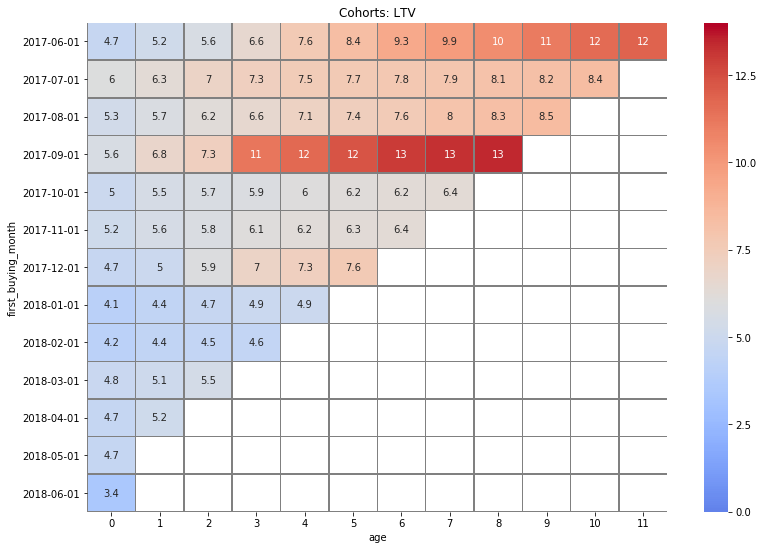

In [112]:
plt.figure(figsize=(13, 9))
plt.title('Cohorts: LTV')
sns.heatmap(output.cumsum(axis=1), annot=True, vmin=0, vmax=14, center= 6, linewidths=0.5,cmap= 'coolwarm', linecolor='grey').set_yticklabels(output.index.date);

Посчитаем усредненный LTV, например, за 6 месяцев - время до которого дожило несколько когорт, чтоб можно было сделать усреднение

In [113]:
output.cumsum(axis=1)[5].mean()

7.969052630207336

### Маркетинг<a name="step16"></a>

#### Сколько денег потратили? Всего / на каждый источник / по времени<a name="step17"></a>

In [114]:
costs.head()

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Всего потрачено

In [115]:
sum_costs = costs['costs'].sum()
sum_costs

329131.62

На каждый источник

In [116]:
costs_by_source = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index()
costs_by_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


По месяцам

In [117]:
costs['month'] = costs['date'].astype('datetime64[M]') 

In [118]:
costs_by_month = costs.groupby('month').agg({'costs': 'sum'}).reset_index()
costs_by_month

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


Text(0.5, 1.0, 'Costs by month')

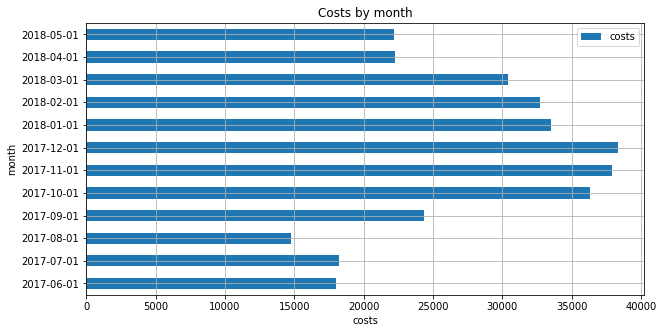

In [119]:
ax =costs_by_month.plot(x='month', y='costs', kind='barh', grid = True, figsize = (10,5))
ax.set_yticklabels(costs_by_month['month'].dt.date)
ax.set_xlabel('costs')
ax.set_ylabel('month')
ax.set_title('Costs by month')

Самые большие траты пришлись на ноябрь и декабрь 2017 года

In [120]:
costs.head()

,source_id,date,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [121]:
costs['month'] = costs['month'].dt.date

In [122]:
costs_month_source = costs.pivot_table(index= 'month', columns= 'source_id', values = 'costs', aggfunc='sum')
costs_month_source

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


Text(0.5, 1.0, 'Costs per month and source')

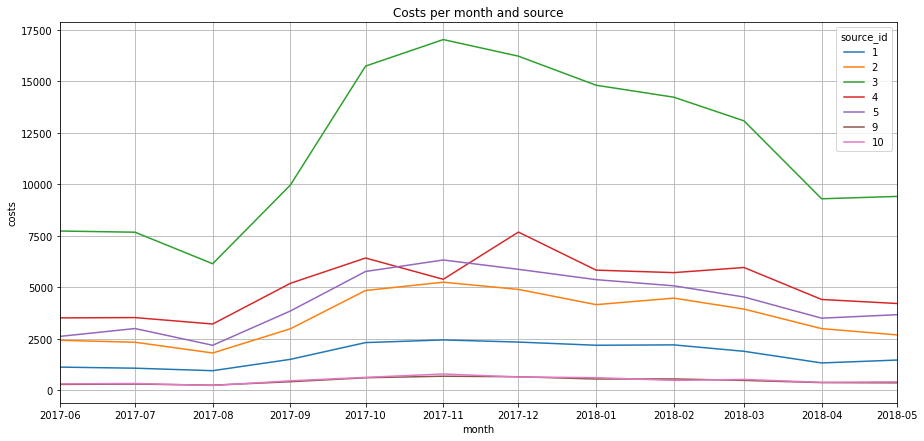

In [123]:
costs_month_source.plot(grid = True, figsize = (15,7)).set_ylabel('costs')
plt.title('Costs per month and source')

#### Сколько стоило привлечение одного покупателя из каждого источника?<a name="step18"></a>

CAC (от англ. customer acquisition cost) — стоимость привлечения клиента. Сумма денег, во сколько обходится новый клиент компании.

In [124]:
visits_by_source = visits.query('start_ts == first_time_session')

In [125]:
customers_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'uid':'nunique'}).rename(columns={'uid':'customers'}).reset_index()
customers_by_source

,source_id,customers
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [126]:
cac = customers_by_source.merge(costs_by_source, on = 'source_id', how = 'outer')

In [127]:
cac['cac'] = cac['costs'] / cac['customers']

In [128]:
cac

,source_id,customers,costs,cac
0,1,2899,20833.27,7.186364
1,2,3506,42806.04,12.209367
2,3,10473,141321.63,13.493901
3,4,10296,61073.60,5.931779
4,5,6931,51757.10,7.467479
5,7,1,NaN,NaN
6,9,1088,5517.49,5.071222
7,10,1329,5822.49,4.381106


Text(0.5, 1.0, 'CAC by source')

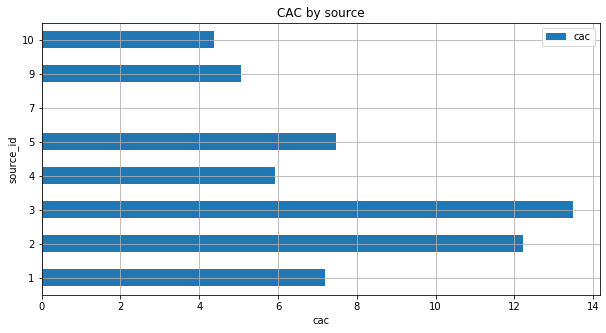

In [129]:
ax = cac.plot(x='source_id', y='cac', kind='barh', grid = True, figsize = (10,5))
ax.set_xlabel('cac')
ax.set_ylabel('source_id')
ax.set_title('CAC by source')

Странные показатели у ресурса 7

In [130]:
visits.query('source_id == 7').head()

,uid,device,start_ts,end_ts,source_id,session_year,session_month,session_week,session_date,session_duration_sec,first_time_session,first_session_month,lifetime
14834,16865718259540502578,desktop,2017-12-02 23:21:00,2017-12-02 23:34:00,7,2017,2017-12-01,48,2017-12-02,780,2017-12-02 23:21:00,2017-12-01,0
33671,11123532188766338866,desktop,2017-12-25 09:49:00,2017-12-25 09:50:00,7,2017,2017-12-01,52,2017-12-25,60,2017-12-25 09:49:00,2017-12-01,0
37719,6003985003549207556,desktop,2018-02-02 11:28:00,2018-02-02 11:30:00,7,2018,2018-02-01,5,2018-02-02,120,2017-10-09 17:28:00,2017-10-01,4
41606,13356978538990003750,desktop,2017-07-05 22:22:00,2017-07-05 22:29:00,7,2017,2017-07-01,27,2017-07-05,420,2017-07-05 22:22:00,2017-07-01,0
42765,4650558368878258850,desktop,2017-10-14 22:26:00,2017-10-14 22:27:00,7,2017,2017-10-01,41,2017-10-14,60,2017-10-14 22:26:00,2017-10-01,0


In [131]:
costs.query('source_id == 7')

,source_id,date,costs,month


Почему то по нему нет никаких данных, видимо, он, либо так ничего и не купил, либо в данных ошибка

Самые большие показатели у ресурса 3

#### На сколько окупились расходы? (ROI)<a name="step19"></a>

Посчитаем коэффициент окупаемости инвестиций (ROI)

In [132]:
costs_by_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [133]:
visits_by_source = visits.query('start_ts == first_time_session')

In [134]:
revenue_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'revenue':'sum'})
revenue_by_source.reset_index()

,source_id,revenue
0,1,31090.55
1,2,46923.61
2,3,54511.24
3,4,56696.83
4,5,52624.02
5,7,1.22
6,9,5759.40
7,10,4450.33


In [135]:
roi = revenue_by_source.merge(costs_by_source, on = 'source_id', how = 'outer')
roi['roi'] = (roi['revenue'] - roi['costs']) / roi['costs']

In [136]:
roi

,source_id,revenue,costs,roi
0,1,31090.55,20833.27,0.492351
1,2,46923.61,42806.04,0.096191
2,3,54511.24,141321.63,-0.614275
3,4,56696.83,61073.60,-0.071664
4,5,52624.02,51757.10,0.016750
5,7,1.22,NaN,NaN
6,9,5759.40,5517.49,0.043844
7,10,4450.33,5822.49,-0.235665


Text(0.5, 1.0, 'ROI by source')

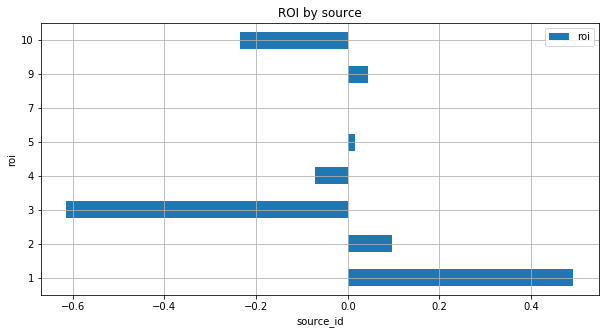

In [137]:
ax = roi.plot(x='source_id', y='roi', kind='barh', grid = True, figsize = (10,5))
ax.set_xlabel('source_id')
ax.set_ylabel('roi')
ax.set_title('ROI by source')

Если значение ROI положительное, предприятие окупает свои инвестиции. Соответственно, если показатель отрицательный, то вложение средств следует пересмотреть. Ресурсам 3, 4 и 10 стоит пересмотреть вложение средств

## Общий вывод<a name="step20"></a>

На основании проведенного нами анализа различных метрик могу сказать, что лучшими источниками являются 1, 2, 3, 5. Источникам 3, 4 и 10 стоит пересмотреть вложение средств. <br>
Не удивительно, что показатели и спрос со временем падает, такой бизнес, как продажа билетов, можно назвать одноразовым. Мало кто из людей покупает билеты стабильно каждый месяц. Особенно в эпоху кризиса, концерты, скорее привилегия. <br>
Небольшой скачок в декабре, возможно, это потому, что кто то покупает билеты в подарок перед новым годом. Остальные месяца, в принципе, похожи.<br>
Советовать что то трудно, ведь бизнес этот нестабилен.<br>
При выборе направления для инвестиций следует ориентироваться на показатели CAC, ROI и выручку.